In [1]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
def _variable_on_cpu(name, shape, initializer, dtype=tf.float32, trainable=True):
    with tf.device('/cpu:0'):
        var = tf.get_variable(name, shape, dtype=dtype,
            initializer=initializer, trainable=trainable)
    return var


# xavier initialization for weight
def _xavier_initializer(shape):
    fan_in = float(shape[-2]) if len(shape) > 1 else float(shape[-1])
    for dim in shape[:-2]:
        fan_in *= float(dim)
    return  tf.truncated_normal_initializer(stddev=1.0/math.sqrt(fan_in))


def _weight_variable_with_decay(name, shape, initializer, wd=None, loss_grp='losses'):
    var = _variable_on_cpu(name, shape, initializer)

    if wd is not None:
        weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection(loss_grp, weight_decay)
    return var


def _bias_variable(name, shape):
    return _variable_on_cpu(name, shape, tf.constant_initializer(0.1))

In [3]:
def _bilinear_initializer(shape):
    filter_size = shape[0]
    upscale_factor = (filter_size + 1) // 2
    if filter_size % 2 == 1:
        center = upscale_factor - 1
    else:
        center = upscale_factor - 0.5
    bilinear = np.zeros([shape[0], shape[1]])
    
    for y in range(shape[0]):
        for x in range(shape[1]):
            value = (1 - abs((y - center)/upscale_factor)) * \
                    (1 - abs((x - center)/upscale_factor))
            bilinear[y, x] = value
    
    weights = np.zeros(shape)
    for i in range(shape[2]):
        weights[:, :, i, i] = bilinear
    return tf.constant_initializer(value=weights, dtype=tf.float32)


# filter in shape of [depth, height, width, out_channels, in_channels]
def _conv2d_transpose(input, filter, output_shape, stride_hw, padding):
    return tf.nn.conv2d_transpose(input,
                                  filter,
                                  output_shape,
                                  strides=[1, stride_hw[0], stride_hw[1], 1],
                                  padding=padding)


# input_tensor in form of [batch, y, x, c]
def _pyramid_2dtensor(input_tensor):
    _, y, x, c = [i for i in input_tensor.get_shape().as_list()]
    new_size_m = tf.constant([y//2, x//2])
    new_size_s = tf.constant([y//4, x//4])
    resized_m = tf.image.resize_images(input_tensor, new_size_m)
    resized_s = tf.image.resize_images(input_tensor, new_size_s)
    return resized_m, resized_s

def _deconv2d_layer(input_tensor, upscale_factor, filter_num, padding, layer_name):
    filter_size = int(2 * upscale_factor - upscale_factor % 2)
    stride_hw = (upscale_factor, upscale_factor)
    with tf.variable_scope(layer_name):
        filter_shape = [ filter_size, filter_size,
                         filter_num,
                         int(input_tensor.get_shape()[3]) ]
        weights = _weight_variable_with_decay(
                    'weights',
                    filter_shape,
                    _bilinear_initializer(filter_shape),
                    wd=None)
        b, h, w, c = input_tensor.get_shape()
        output_shape = tf.stack([b, h * upscale_factor, w * upscale_factor, filter_num])
        res = _conv2d_transpose(input_tensor, weights, output_shape, stride_hw, padding)
    return res         

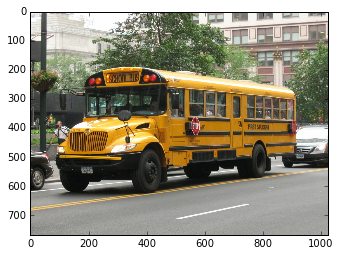

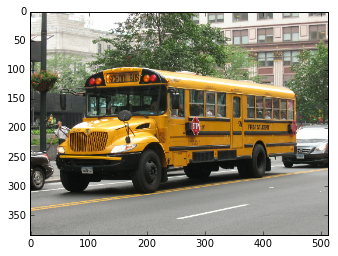

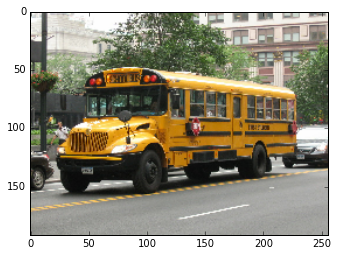

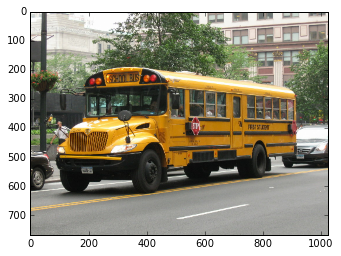

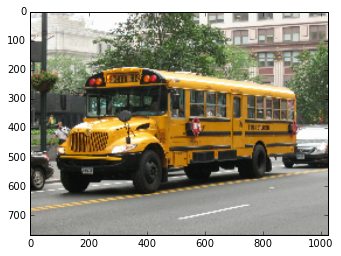

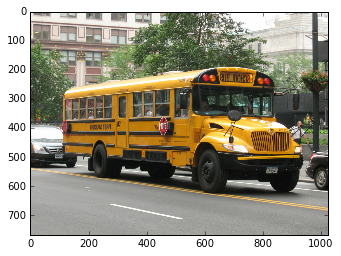

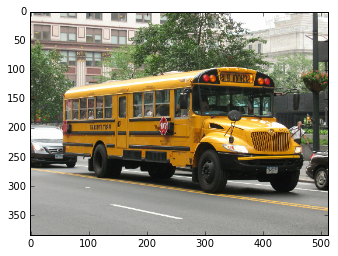

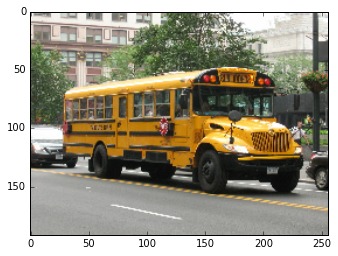

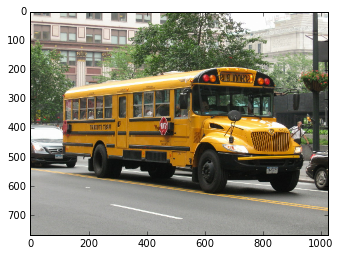

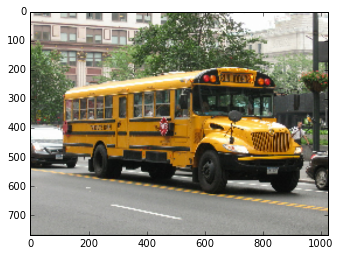

In [4]:
tf.reset_default_graph()
filename='./cnn_resize_data/school_bus.jpg'
with tf.gfile.FastGFile(filename, 'rb') as f:
    image_data1 = f.read()
filename='./cnn_resize_data/school_bus2.jpg'
with tf.gfile.FastGFile(filename, 'rb') as f:
    image_data2 = f.read()
    
jpeg_image1 = tf.image.decode_jpeg(image_data1, channels=3)
jpeg_image2 = tf.image.decode_jpeg(image_data2, channels=3)
image1 = tf.cast(jpeg_image1, tf.float32) / 255. 
image2 = tf.cast(jpeg_image2, tf.float32) / 255. 
image1 = tf.reshape(image1, [768, 1024, 3])
image2 = tf.reshape(image2, [768, 1024, 3])

input_tensor = tf.stack([image1, image2], axis=0)
# input_tensor = tf.expand_dims(image, axis=0)
half_image, quarter_image = _pyramid_2dtensor(input_tensor)
restore_image1 = _deconv2d_layer(half_image, 2,
                      filter_num=half_image.get_shape()[3],
                      padding='SAME',
                      layer_name='deconv_x2')
restore_image2 = _deconv2d_layer(quarter_image, 4,
                      filter_num=quarter_image.get_shape()[3],
                      padding='SAME',
                      layer_name='deconv_x4')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    original_img = sess.run(input_tensor)
    half_img, quarter_img = sess.run([half_image, quarter_image])
    restore_img1 = sess.run(restore_image1)
    restore_img2 = sess.run(restore_image2)

    for i in range(original_img.shape[0]):
        plt.figure(i*5+1)
        plt.imshow(original_img[i])
        plt.figure(i*5+2)
        plt.imshow(half_img[i])
        plt.figure(i*5+3)
        plt.imshow(quarter_img[i])
        plt.figure(i*5+4)
        plt.imshow(restore_img1[i])
        plt.figure(i*5+5)
        plt.imshow(restore_img2[i])


In [5]:
# trilinear initialization for weight
def _trilinear_initializer(shape):
    filter_size = shape[0]
    upscale_factor = (filter_size + 1) // 2
    if filter_size % 2 == 1:
        center = upscale_factor - 1
    else:
        center = upscale_factor - 0.5

    trilinear = np.zeros([shape[0], shape[1], shape[2]])
    for z in range(shape[0]):
        for y in range(shape[1]):
            for x in range(shape[2]):
                value = (1 - abs((z - center)/upscale_factor)) * \
                        (1 - abs((y - center)/upscale_factor)) * \
                        (1 - abs((x - center)/upscale_factor))
                trilinear[z, y, x] = value

    weights = np.zeros(shape)
    for i in range(shape[3]):
        weights[:, :, :, i, i] = trilinear

    return tf.constant_initializer(value=weights, dtype=tf.float32)


# filter in shape of [depth, height, width, out_channels, in_channels]
def _conv3d_transpose(input, filter, output_shape, stride_dhw, padding):
    return tf.nn.conv3d_transpose(input,
                                  filter,
                                  output_shape,
                                  strides=[1, stride_dhw[0], stride_dhw[1], stride_dhw[2], 1],
                                  padding=padding)


# input_tensor in form of [batch, z, y, x, c]
def _pyramid_3dtensor(input_tensor):
    _, z, y, x, c = [i for i in input_tensor.get_shape().as_list()]

    # resize x & y dims
    reshaped = tf.reshape(input_tensor, [-1, y, x, c])
    new_size_m = tf.constant([y//2, x//2])
    new_size_s = tf.constant([y//4, x//4])
    resized_m = tf.image.resize_images(reshaped, new_size_m)
    resized_s = tf.image.resize_images(reshaped, new_size_s)
    reshaped_m = tf.reshape(resized_m, [-1, z, y//2, x//2, c])
    reshaped_s = tf.reshape(resized_s, [-1, z, y//4, x//4, c])   
    # resize z dim
    transposed_m = tf.transpose(reshaped_m, [0, 3, 1, 2, 4])
    transposed_s = tf.transpose(reshaped_s, [0, 3, 1, 2, 4])
    reshaped_m = tf.reshape(transposed_m, [-1, z, y//2, c])
    reshaped_s = tf.reshape(transposed_s, [-1, z, y//4, c])     
    new_size_m = tf.constant([z//2, y//2])
    new_size_s = tf.constant([z//4, y//4])
    resized_m = tf.image.resize_images(reshaped_m, new_size_m)
    resized_s = tf.image.resize_images(reshaped_s, new_size_s)
    reshaped_m = tf.reshape(resized_m, [-1, x//2, z//2, y//2, c])
    reshaped_s = tf.reshape(resized_s, [-1, x//4, z//4, y//4, c])
    # transpose to z,y,x order
    transposed_m = tf.transpose(reshaped_m, [0, 2, 3, 1, 4])
    transposed_s = tf.transpose(reshaped_s, [0, 2, 3, 1, 4])  
    print(transposed_m)
    print(transposed_s)    
    return transposed_m, transposed_s


def _deconv3d_layer(input_tensor,
                    upscale_factor,
                    filter_num,
                    padding,
                    layer_name,
                    act=tf.identity):
    filter_size = 2 * upscale_factor - upscale_factor % 2
    stride_dhw = (upscale_factor, upscale_factor, upscale_factor)
    with tf.variable_scope(layer_name):
        filter_shape = [ filter_size, filter_size, filter_size,
                         filter_num,
                         int(input_tensor.get_shape()[4]) ]
        weights = _weight_variable_with_decay(
                    'weights',
                    filter_shape,
                    _trilinear_initializer(filter_shape),
                    wd=None)
        b, d, h, w, c = input_tensor.get_shape()
        output_shape = tf.stack([b, d * upscale_factor, h * upscale_factor, w * upscale_factor, filter_num])
        res = _conv3d_transpose(input_tensor, weights, output_shape, stride_dhw, padding)
    return res

In [6]:
import cv2
import matplotlib.animation as animation
from IPython.display import HTML

def render_zaxis_gif(images, gif_name):
    fig = plt.figure()
    anim = plt.imshow(images[0], cmap=plt.cm.bone)
    def update(i):
        anim.set_array(images[i])
        return anim,

    a = animation.FuncAnimation(fig, update, frames=range(len(images)), interval=50, blit=True)
    a.save(gif_name, writer='imagemagick')


def render_zaxis_video(images_zyx, output_path):
    codec='MJPG'
    fourcc = cv2.VideoWriter_fourcc(*codec)
    h = images_zyx.shape[1]
    w = images_zyx.shape[2]
    #images_zyx = (images_zyx * 255).astype(np.uint8)
    writer = cv2.VideoWriter(output_path, fourcc, 15, (int(w), int(h)), isColor=True)

    for img in images_zyx:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        writer.write(img)
    writer.release()

Tensor("ExpandDims:0", shape=(2, 80, 80, 80, 1), dtype=uint8)
Tensor("transpose_2:0", shape=(2, 40, 40, 40, 1), dtype=float32)
Tensor("transpose_3:0", shape=(2, 20, 20, 20, 1), dtype=float32)
batch =  2


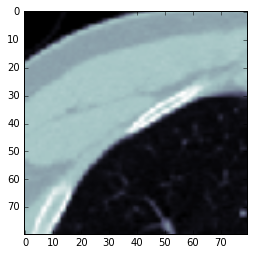

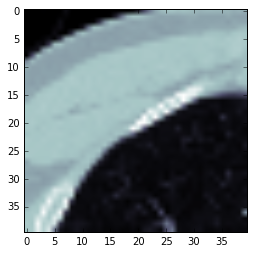

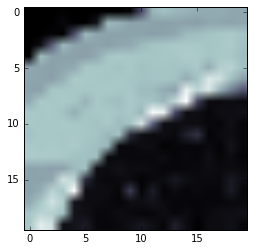

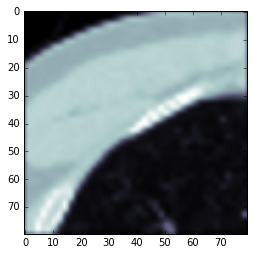

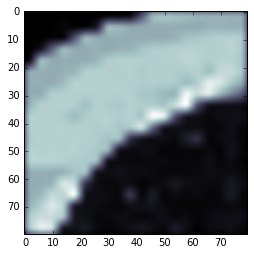

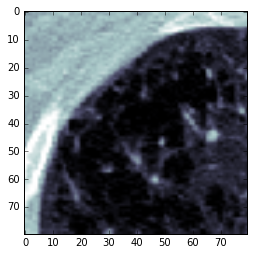

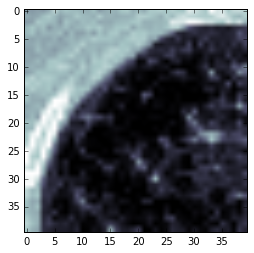

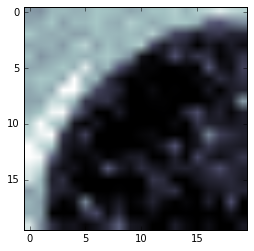

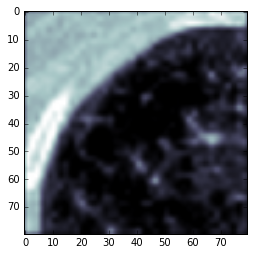

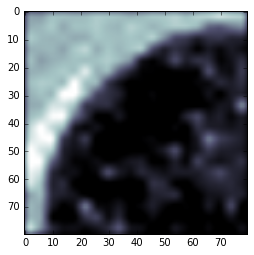

In [7]:

tf.reset_default_graph()
     
image3d_1 = np.load('./cnn_resize_data/80x80x80/5922_kaggle12.npy')
image3d_2 = np.load('./cnn_resize_data/80x80x80/5929_kaggle19.npy')

input_tensor = tf.stack([image3d_1, image3d_2], axis=0)
input_tensor = tf.expand_dims(input_tensor, axis=-1) # add dim for channel
print(input_tensor)
half_image3d, quarter_image3d = _pyramid_3dtensor(input_tensor)
restore_image3d1 = _deconv3d_layer(half_image3d, 2,
                          filter_num=half_image3d.get_shape()[4],
                          padding='SAME',
                          layer_name='deconv_x2')
restore_image3d2 = _deconv3d_layer(quarter_image3d, 4,
                          filter_num=quarter_image3d.get_shape()[4],
                          padding='SAME',
                          layer_name='deconv_x4')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    img3d = sess.run(input_tensor)
    half_img3d, quarter_img3d = sess.run([half_image3d, quarter_image3d])
    restore_img3d1, restore_img3d2 = sess.run([restore_image3d1, restore_image3d2])

print('batch = ', img3d.shape[0])
for i in range(img3d.shape[0]):
    render_zaxis_gif(img3d[i].squeeze(), './cnn_resize_data/out/origin_img3d_' + str(i) + '.gif')
    render_zaxis_gif(half_img3d[i].squeeze(), './cnn_resize_data/out/half_img3d_' + str(i) + '.gif')
    render_zaxis_gif(quarter_img3d[i].squeeze(), './cnn_resize_data/out/quart_img3d_' + str(i) + '.gif')
    render_zaxis_gif(restore_img3d1[i].squeeze(), './cnn_resize_data/out/restore_img3d1_' + str(i) + '.gif')
    render_zaxis_gif(restore_img3d2[i].squeeze(), './cnn_resize_data/out/restore_img3d2_' + str(i) + '.gif')


In [8]:
from IPython.display import Image, display
display(Image(url='././cnn_resize_data/out/half_img3d_0.gif'))

In [ ]:
# References:
http://cv-tricks.com/image-segmentation/transpose-convolution-in-tensorflow/
https://github.com/ljanyst/image-segmentation-fcn/blob/master/upscale.py
http://warmspringwinds.github.io/tensorflow/tf-slim/2016/11/22/upsampling-and-image-segmentation-with-tensorflow-and-tf-slim/    